# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

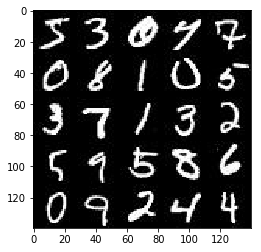

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

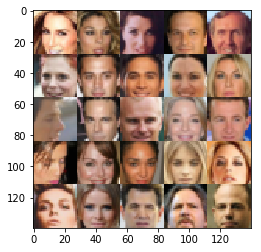

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [62]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    def swish(x):
        #return x * tf.sigmoid(x)
        return tf.maximum(x*0.1, x)
        
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = swish(x1)
        #14x14
        
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = swish(x2)
        #7x7
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = swish(x3)
        #4x4
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.glorot_uniform_initializer())
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [63]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    with tf.variable_scope('generator', reuse = not is_train):
        # TODO: Implement Function
        x1 = tf.layers.dense(z, 4*4*256,kernel_initializer=tf.glorot_uniform_initializer())
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        #4x4

        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        #7x7
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)
        #14x14

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #28x28
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [64]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_m = generator(input_z, out_channel_dim)
    dis_r, dis_r_logits = discriminator(input_real, reuse=False)
    dis_f, dis_f_logits = discriminator(gen_m, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_r_logits, labels=tf.ones_like(dis_r_logits)*.95))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_f_logits, labels=tf.zeros_like(dis_f_logits)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_f_logits, labels=tf.ones_like(dis_f_logits)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [65]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [66]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [67]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    
    # TODO: Build Model
    _, w, h, c = data_shape
    
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    else:
        out_channel_dim = 1
    
    input_real, input_z, lr = model_inputs(w, h, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_op, g_op = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sample_images = 25
    
    
    step = 1
    with tf.Session() as sess:       
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_op, feed_dict={input_real: batch_images*2, 
                                              input_z: batch_z, 
                                              lr: learning_rate})
                
                _ = sess.run(g_op, feed_dict={input_z: batch_z, 
                                              input_real: batch_images*2, 
                                              lr: learning_rate})
                
                _ = sess.run(g_op, feed_dict={input_z: batch_z, 
                              input_real: batch_images*2, 
                              lr: learning_rate})
                

                if step%50==0:
                    dl, gl = sess.run([d_loss, g_loss], feed_dict={input_real: batch_images, 
                                              input_z: batch_z})
                    print('Step: {}-{} | Generator Loss: {:.4f} | Discriminator Loss: {:.4f}'.format(epoch_i, step, gl, dl))
                    
                if step%400==1:
                    show_generator_output(sess, sample_images, input_z, out_channel_dim, data_image_mode)
                step+=1
            saver.save(sess, './checkpoints/generator.ckpt')
        print("Final output")
        show_generator_output(sess, sample_images, input_z, out_channel_dim, data_image_mode)
                
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

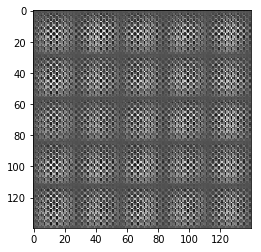

Step: 0-50 | Generator Loss: 2.8372 | Discriminator Loss: 2.2059
Step: 0-100 | Generator Loss: 3.5655 | Discriminator Loss: 1.7576
Step: 0-150 | Generator Loss: 1.0295 | Discriminator Loss: 1.1201
Step: 0-200 | Generator Loss: 1.4318 | Discriminator Loss: 0.8475
Step: 0-250 | Generator Loss: 0.3285 | Discriminator Loss: 1.9376
Step: 0-300 | Generator Loss: 1.0153 | Discriminator Loss: 1.2117
Step: 0-350 | Generator Loss: 0.7502 | Discriminator Loss: 1.5962
Step: 0-400 | Generator Loss: 0.6219 | Discriminator Loss: 1.3608


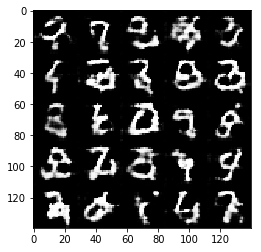

Step: 0-450 | Generator Loss: 0.3273 | Discriminator Loss: 1.6533
Step: 0-500 | Generator Loss: 0.3385 | Discriminator Loss: 1.7829
Step: 0-550 | Generator Loss: 0.3058 | Discriminator Loss: 1.8693
Step: 0-600 | Generator Loss: 1.0444 | Discriminator Loss: 1.2251
Step: 0-650 | Generator Loss: 0.6857 | Discriminator Loss: 1.2753
Step: 0-700 | Generator Loss: 2.3090 | Discriminator Loss: 2.1249
Step: 0-750 | Generator Loss: 1.4910 | Discriminator Loss: 2.0579
Step: 0-800 | Generator Loss: 0.6762 | Discriminator Loss: 1.5952


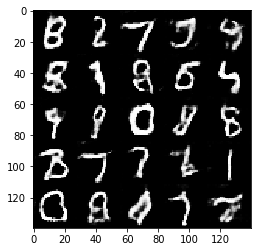

Step: 0-850 | Generator Loss: 1.0667 | Discriminator Loss: 1.9133
Step: 0-900 | Generator Loss: 0.5500 | Discriminator Loss: 1.8551
Step: 0-950 | Generator Loss: 0.7196 | Discriminator Loss: 1.6245
Step: 0-1000 | Generator Loss: 0.4978 | Discriminator Loss: 2.0356
Step: 0-1050 | Generator Loss: 1.3306 | Discriminator Loss: 2.0393
Step: 0-1100 | Generator Loss: 1.5491 | Discriminator Loss: 3.2861
Step: 0-1150 | Generator Loss: 0.7448 | Discriminator Loss: 2.6257
Step: 0-1200 | Generator Loss: 1.1211 | Discriminator Loss: 2.4921


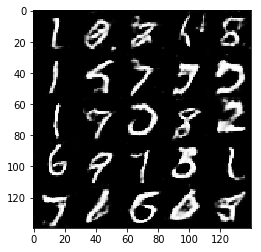

Step: 0-1250 | Generator Loss: 0.6601 | Discriminator Loss: 3.6629
Step: 0-1300 | Generator Loss: 0.9822 | Discriminator Loss: 4.6060
Step: 0-1350 | Generator Loss: 0.3888 | Discriminator Loss: 2.6646
Step: 0-1400 | Generator Loss: 1.1578 | Discriminator Loss: 6.5421
Step: 0-1450 | Generator Loss: 0.4565 | Discriminator Loss: 5.1947
Step: 0-1500 | Generator Loss: 1.4009 | Discriminator Loss: 5.8334
Step: 0-1550 | Generator Loss: 0.4690 | Discriminator Loss: 4.3546
Step: 0-1600 | Generator Loss: 0.3510 | Discriminator Loss: 4.5059


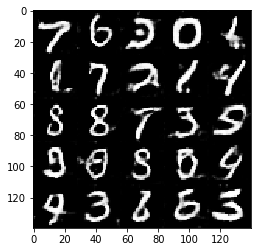

Step: 0-1650 | Generator Loss: 0.6002 | Discriminator Loss: 6.1932
Step: 0-1700 | Generator Loss: 1.0716 | Discriminator Loss: 6.3733
Step: 0-1750 | Generator Loss: 0.5567 | Discriminator Loss: 3.6218
Step: 0-1800 | Generator Loss: 1.0508 | Discriminator Loss: 4.2704
Step: 0-1850 | Generator Loss: 1.1484 | Discriminator Loss: 6.8831
Step: 1-1900 | Generator Loss: 1.1919 | Discriminator Loss: 6.6632
Step: 1-1950 | Generator Loss: 1.1210 | Discriminator Loss: 6.3108
Step: 1-2000 | Generator Loss: 0.9954 | Discriminator Loss: 6.6481


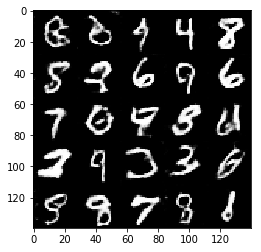

Step: 1-2050 | Generator Loss: 1.5707 | Discriminator Loss: 8.4130
Step: 1-2100 | Generator Loss: 1.4542 | Discriminator Loss: 7.0583
Step: 1-2150 | Generator Loss: 0.3708 | Discriminator Loss: 7.7859
Step: 1-2200 | Generator Loss: 1.0259 | Discriminator Loss: 5.7206
Step: 1-2250 | Generator Loss: 0.8051 | Discriminator Loss: 6.4270
Step: 1-2300 | Generator Loss: 2.0938 | Discriminator Loss: 6.5891
Step: 1-2350 | Generator Loss: 2.1458 | Discriminator Loss: 7.2869
Step: 1-2400 | Generator Loss: 3.5413 | Discriminator Loss: 6.8374


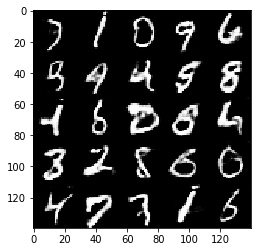

Step: 1-2450 | Generator Loss: 2.8401 | Discriminator Loss: 9.0907
Step: 1-2500 | Generator Loss: 1.9887 | Discriminator Loss: 8.6103
Step: 1-2550 | Generator Loss: 2.0635 | Discriminator Loss: 5.7167
Step: 1-2600 | Generator Loss: 1.7581 | Discriminator Loss: 6.8707
Step: 1-2650 | Generator Loss: 1.2852 | Discriminator Loss: 6.2172
Step: 1-2700 | Generator Loss: 1.5447 | Discriminator Loss: 7.7404
Step: 1-2750 | Generator Loss: 0.2120 | Discriminator Loss: 8.3512
Step: 1-2800 | Generator Loss: 0.1098 | Discriminator Loss: 6.4791


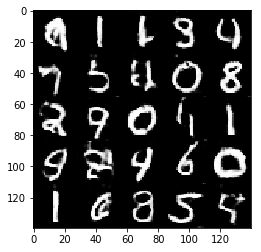

Step: 1-2850 | Generator Loss: 0.5521 | Discriminator Loss: 7.3638
Step: 1-2900 | Generator Loss: 1.6844 | Discriminator Loss: 7.6851
Step: 1-2950 | Generator Loss: 2.3896 | Discriminator Loss: 8.6176
Step: 1-3000 | Generator Loss: 0.4176 | Discriminator Loss: 7.7823
Step: 1-3050 | Generator Loss: 2.5940 | Discriminator Loss: 9.8519
Step: 1-3100 | Generator Loss: 1.6812 | Discriminator Loss: 8.2456
Step: 1-3150 | Generator Loss: 0.5799 | Discriminator Loss: 7.2572
Step: 1-3200 | Generator Loss: 1.6644 | Discriminator Loss: 7.5995


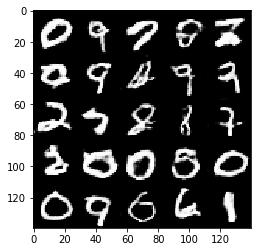

Step: 1-3250 | Generator Loss: 1.1510 | Discriminator Loss: 7.7063
Step: 1-3300 | Generator Loss: 2.1894 | Discriminator Loss: 9.7576
Step: 1-3350 | Generator Loss: 1.3425 | Discriminator Loss: 6.9331
Step: 1-3400 | Generator Loss: 0.3198 | Discriminator Loss: 8.7334
Step: 1-3450 | Generator Loss: 0.4738 | Discriminator Loss: 8.0756
Step: 1-3500 | Generator Loss: 0.8470 | Discriminator Loss: 7.1764
Step: 1-3550 | Generator Loss: 0.8486 | Discriminator Loss: 10.4407
Step: 1-3600 | Generator Loss: 0.2636 | Discriminator Loss: 6.9635


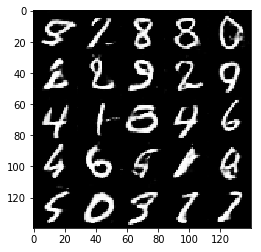

Step: 1-3650 | Generator Loss: 0.5321 | Discriminator Loss: 7.4319
Step: 1-3700 | Generator Loss: 0.0677 | Discriminator Loss: 4.6943
Step: 1-3750 | Generator Loss: 0.6970 | Discriminator Loss: 7.2616
Final output


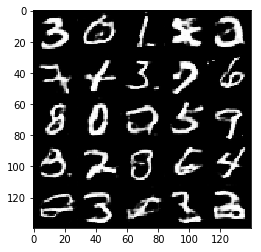

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.35

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

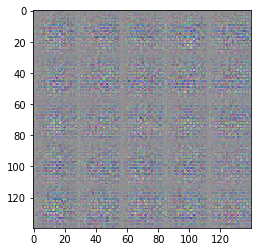

Step: 0-50 | Generator Loss: 3.4803 | Discriminator Loss: 0.7049
Step: 0-100 | Generator Loss: 0.6565 | Discriminator Loss: 1.3745
Step: 0-150 | Generator Loss: 0.9264 | Discriminator Loss: 1.0618
Step: 0-200 | Generator Loss: 0.8965 | Discriminator Loss: 1.1588
Step: 0-250 | Generator Loss: 0.6434 | Discriminator Loss: 1.4108
Step: 0-300 | Generator Loss: 0.8868 | Discriminator Loss: 1.2177
Step: 0-350 | Generator Loss: 0.3679 | Discriminator Loss: 1.7640
Step: 0-400 | Generator Loss: 1.2249 | Discriminator Loss: 1.4427


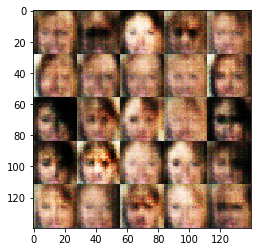

Step: 0-450 | Generator Loss: 0.8971 | Discriminator Loss: 1.4460
Step: 0-500 | Generator Loss: 0.5950 | Discriminator Loss: 1.4178
Step: 0-550 | Generator Loss: 0.4272 | Discriminator Loss: 1.6350
Step: 0-600 | Generator Loss: 0.9618 | Discriminator Loss: 1.4895
Step: 0-650 | Generator Loss: 0.7115 | Discriminator Loss: 1.4358
Step: 0-700 | Generator Loss: 0.5872 | Discriminator Loss: 1.5439
Step: 0-750 | Generator Loss: 0.7582 | Discriminator Loss: 1.3958
Step: 0-800 | Generator Loss: 0.5129 | Discriminator Loss: 1.4621


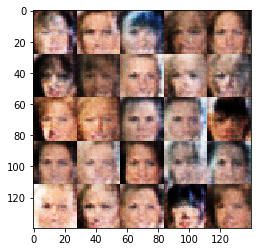

Step: 0-850 | Generator Loss: 0.2736 | Discriminator Loss: 1.8746
Step: 0-900 | Generator Loss: 0.5409 | Discriminator Loss: 1.5702
Step: 0-950 | Generator Loss: 0.6747 | Discriminator Loss: 1.5035
Step: 0-1000 | Generator Loss: 0.4706 | Discriminator Loss: 1.4363
Step: 0-1050 | Generator Loss: 0.7017 | Discriminator Loss: 1.4146
Step: 0-1100 | Generator Loss: 0.6079 | Discriminator Loss: 1.3499
Step: 0-1150 | Generator Loss: 0.6697 | Discriminator Loss: 1.3839
Step: 0-1200 | Generator Loss: 0.5356 | Discriminator Loss: 1.4107


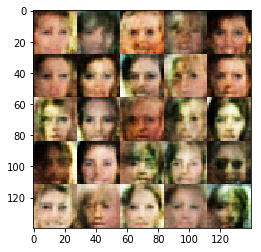

Step: 0-1250 | Generator Loss: 0.5215 | Discriminator Loss: 1.4788
Step: 0-1300 | Generator Loss: 0.8614 | Discriminator Loss: 1.3604
Step: 0-1350 | Generator Loss: 0.6521 | Discriminator Loss: 1.7495
Step: 0-1400 | Generator Loss: 0.3803 | Discriminator Loss: 1.5712
Step: 0-1450 | Generator Loss: 0.3288 | Discriminator Loss: 1.7521
Step: 0-1500 | Generator Loss: 0.3984 | Discriminator Loss: 1.6178
Step: 0-1550 | Generator Loss: 0.3971 | Discriminator Loss: 1.8386
Step: 0-1600 | Generator Loss: 0.3704 | Discriminator Loss: 1.6905


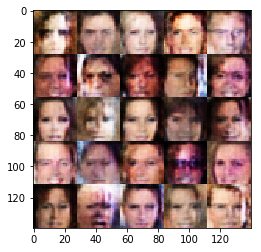

Step: 0-1650 | Generator Loss: 0.4312 | Discriminator Loss: 1.5351
Step: 0-1700 | Generator Loss: 0.5193 | Discriminator Loss: 1.5351
Step: 0-1750 | Generator Loss: 0.6933 | Discriminator Loss: 1.4551
Step: 0-1800 | Generator Loss: 0.7365 | Discriminator Loss: 1.3682
Step: 0-1850 | Generator Loss: 0.5298 | Discriminator Loss: 1.3710
Step: 0-1900 | Generator Loss: 0.5408 | Discriminator Loss: 1.4437
Step: 0-1950 | Generator Loss: 0.6610 | Discriminator Loss: 1.2698
Step: 0-2000 | Generator Loss: 0.5616 | Discriminator Loss: 1.3623


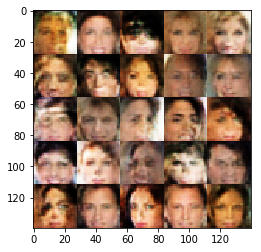

Step: 0-2050 | Generator Loss: 0.6612 | Discriminator Loss: 1.3898
Step: 0-2100 | Generator Loss: 0.4172 | Discriminator Loss: 1.5124
Step: 0-2150 | Generator Loss: 0.4599 | Discriminator Loss: 1.5231
Step: 0-2200 | Generator Loss: 0.4668 | Discriminator Loss: 1.4273
Step: 0-2250 | Generator Loss: 0.4148 | Discriminator Loss: 1.6845
Step: 0-2300 | Generator Loss: 0.4772 | Discriminator Loss: 1.4218
Step: 0-2350 | Generator Loss: 0.3826 | Discriminator Loss: 1.6707
Step: 0-2400 | Generator Loss: 0.6019 | Discriminator Loss: 1.3727


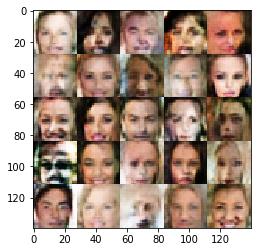

Step: 0-2450 | Generator Loss: 0.6483 | Discriminator Loss: 1.3977
Step: 0-2500 | Generator Loss: 0.5764 | Discriminator Loss: 1.4236
Step: 0-2550 | Generator Loss: 0.4052 | Discriminator Loss: 1.5726
Step: 0-2600 | Generator Loss: 0.4895 | Discriminator Loss: 1.4124
Step: 0-2650 | Generator Loss: 0.4295 | Discriminator Loss: 1.5613
Step: 0-2700 | Generator Loss: 0.2963 | Discriminator Loss: 1.6866
Step: 0-2750 | Generator Loss: 0.2991 | Discriminator Loss: 1.7093
Step: 0-2800 | Generator Loss: 0.3474 | Discriminator Loss: 1.6799


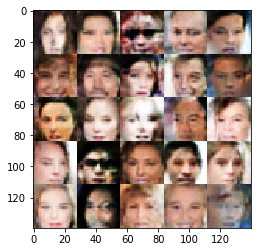

Step: 0-2850 | Generator Loss: 0.6777 | Discriminator Loss: 1.2297
Step: 0-2900 | Generator Loss: 0.4031 | Discriminator Loss: 1.5455
Step: 0-2950 | Generator Loss: 0.4815 | Discriminator Loss: 1.3776
Step: 0-3000 | Generator Loss: 0.3416 | Discriminator Loss: 1.5844
Step: 0-3050 | Generator Loss: 0.3489 | Discriminator Loss: 1.6199
Step: 0-3100 | Generator Loss: 0.4180 | Discriminator Loss: 1.5453
Step: 0-3150 | Generator Loss: 0.4706 | Discriminator Loss: 1.4608
Step: 0-3200 | Generator Loss: 0.2957 | Discriminator Loss: 1.7647


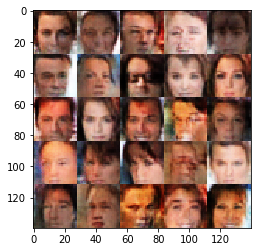

Step: 0-3250 | Generator Loss: 0.3565 | Discriminator Loss: 1.5994
Step: 0-3300 | Generator Loss: 0.4309 | Discriminator Loss: 1.5131
Step: 0-3350 | Generator Loss: 0.3681 | Discriminator Loss: 1.5817
Step: 0-3400 | Generator Loss: 0.3675 | Discriminator Loss: 1.5521
Step: 0-3450 | Generator Loss: 0.4656 | Discriminator Loss: 1.4489
Step: 0-3500 | Generator Loss: 0.3564 | Discriminator Loss: 1.5967
Step: 0-3550 | Generator Loss: 0.3753 | Discriminator Loss: 1.5451
Step: 0-3600 | Generator Loss: 0.4525 | Discriminator Loss: 1.4910


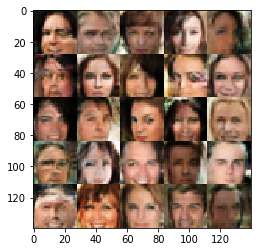

Step: 0-3650 | Generator Loss: 0.4714 | Discriminator Loss: 1.5202
Step: 0-3700 | Generator Loss: 0.6938 | Discriminator Loss: 1.3778
Step: 0-3750 | Generator Loss: 0.4211 | Discriminator Loss: 1.6404
Step: 0-3800 | Generator Loss: 0.5161 | Discriminator Loss: 1.4483
Step: 0-3850 | Generator Loss: 0.4439 | Discriminator Loss: 1.4470
Step: 0-3900 | Generator Loss: 0.5693 | Discriminator Loss: 1.3476
Step: 0-3950 | Generator Loss: 0.3880 | Discriminator Loss: 1.6060
Step: 0-4000 | Generator Loss: 0.4545 | Discriminator Loss: 1.4387


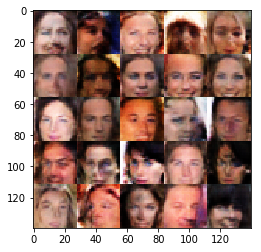

Step: 0-4050 | Generator Loss: 0.3175 | Discriminator Loss: 1.6849
Step: 0-4100 | Generator Loss: 0.2984 | Discriminator Loss: 1.6756
Step: 0-4150 | Generator Loss: 0.5823 | Discriminator Loss: 1.3290
Step: 0-4200 | Generator Loss: 0.7603 | Discriminator Loss: 1.1698
Step: 0-4250 | Generator Loss: 0.6106 | Discriminator Loss: 1.1289
Step: 0-4300 | Generator Loss: 0.3985 | Discriminator Loss: 1.5523
Step: 0-4350 | Generator Loss: 0.5557 | Discriminator Loss: 1.3004
Step: 0-4400 | Generator Loss: 0.4896 | Discriminator Loss: 1.4136


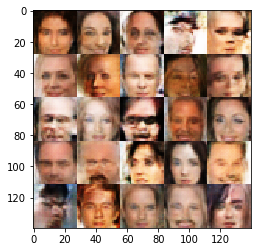

Step: 0-4450 | Generator Loss: 0.3741 | Discriminator Loss: 1.6229
Step: 0-4500 | Generator Loss: 0.3732 | Discriminator Loss: 1.6831
Step: 0-4550 | Generator Loss: 0.6754 | Discriminator Loss: 1.3443
Step: 0-4600 | Generator Loss: 0.6340 | Discriminator Loss: 1.2329
Step: 0-4650 | Generator Loss: 0.4755 | Discriminator Loss: 1.5142
Step: 0-4700 | Generator Loss: 0.4487 | Discriminator Loss: 1.4723
Step: 0-4750 | Generator Loss: 0.2618 | Discriminator Loss: 1.8455
Step: 0-4800 | Generator Loss: 0.5487 | Discriminator Loss: 1.3210


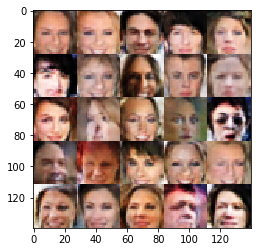

Step: 0-4850 | Generator Loss: 0.2947 | Discriminator Loss: 1.7284
Step: 0-4900 | Generator Loss: 0.2518 | Discriminator Loss: 1.8996
Step: 0-4950 | Generator Loss: 0.2911 | Discriminator Loss: 1.7442
Step: 0-5000 | Generator Loss: 0.5941 | Discriminator Loss: 1.3779
Step: 0-5050 | Generator Loss: 0.3749 | Discriminator Loss: 1.5874
Step: 0-5100 | Generator Loss: 0.5415 | Discriminator Loss: 1.4603
Step: 0-5150 | Generator Loss: 0.6102 | Discriminator Loss: 1.3650
Step: 0-5200 | Generator Loss: 0.5041 | Discriminator Loss: 1.4146


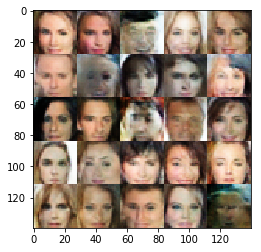

Step: 0-5250 | Generator Loss: 0.5023 | Discriminator Loss: 1.3606
Step: 0-5300 | Generator Loss: 0.4698 | Discriminator Loss: 1.4950
Step: 0-5350 | Generator Loss: 0.4654 | Discriminator Loss: 1.5123
Step: 0-5400 | Generator Loss: 0.8548 | Discriminator Loss: 1.3251
Step: 0-5450 | Generator Loss: 0.3508 | Discriminator Loss: 1.7873
Step: 0-5500 | Generator Loss: 0.3986 | Discriminator Loss: 1.7008
Step: 0-5550 | Generator Loss: 0.6218 | Discriminator Loss: 1.5160
Step: 0-5600 | Generator Loss: 0.4301 | Discriminator Loss: 1.6122


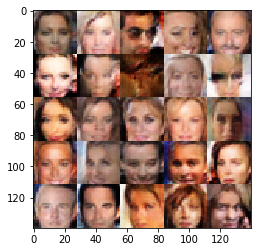

Step: 0-5650 | Generator Loss: 0.5440 | Discriminator Loss: 1.3089
Step: 0-5700 | Generator Loss: 0.3065 | Discriminator Loss: 1.7753
Step: 0-5750 | Generator Loss: 0.3059 | Discriminator Loss: 1.7798
Step: 0-5800 | Generator Loss: 0.3076 | Discriminator Loss: 1.7698
Step: 0-5850 | Generator Loss: 0.4566 | Discriminator Loss: 1.5743
Step: 0-5900 | Generator Loss: 0.5564 | Discriminator Loss: 1.5237
Step: 0-5950 | Generator Loss: 0.6730 | Discriminator Loss: 1.4861
Step: 0-6000 | Generator Loss: 0.6064 | Discriminator Loss: 1.7444


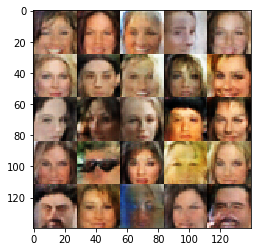

Step: 0-6050 | Generator Loss: 0.6073 | Discriminator Loss: 1.8420
Step: 0-6100 | Generator Loss: 0.5180 | Discriminator Loss: 1.4893
Step: 0-6150 | Generator Loss: 0.3771 | Discriminator Loss: 1.5629
Step: 0-6200 | Generator Loss: 0.4294 | Discriminator Loss: 1.4770
Step: 0-6250 | Generator Loss: 0.5832 | Discriminator Loss: 1.3352
Step: 0-6300 | Generator Loss: 0.5212 | Discriminator Loss: 1.5925
Final output


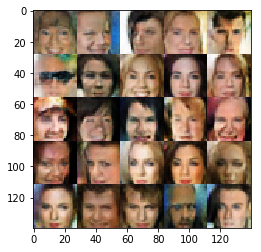

In [89]:
batch_size = 32
z_dim = 100
learning_rate = 0.00022
beta1 = 0.35


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.